# Imports

In [29]:
# 📚 Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings


# 📝 Text Processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
# ⚙️ Settings
pd.set_option('display.max_columns', None) # display all columns
warnings.filterwarnings('ignore') # ignore warnings

# First Analysis

In [4]:
data = pd.read_csv('/Users/mac/IronHacks/W7/project-3-nlp/dataset/training_data.csv', sep="\t", header=None)
df = data.copy()

In [5]:
df.columns = ['is_fake_news', 'Headline']

In [6]:
df.sample(10)

,is_fake_news,Headline
15680,0,hysterical! president trump calls out obama: ‚...
18228,1,silicon valley blasts senate proposal to tax s...
8588,0,this one image reveals the right-wing racism t...
30637,1,u.n. envoy not carrying u.s. government messag...
15768,0,orrin hatch shuts down liberal hack comparing ...
19107,1,republicans fail again to kill off obamacare i...
32365,1,beijing hits brakes on subway boom over debt c...
24511,1,house adopts massive defense bill\tsees change...
8575,0,that constitution the bundy terrorists tote ar...
18960,1,trump opponents urge u.s. supreme court to rul...


In [7]:
df.is_fake_news.value_counts()

is_fake_news
0    17572
1    16580
Name: count, dtype: int64

In [8]:
df.shape

(34152, 2)

Text(0.5, 1.0, 'Distribution: Real vs. Fake News')

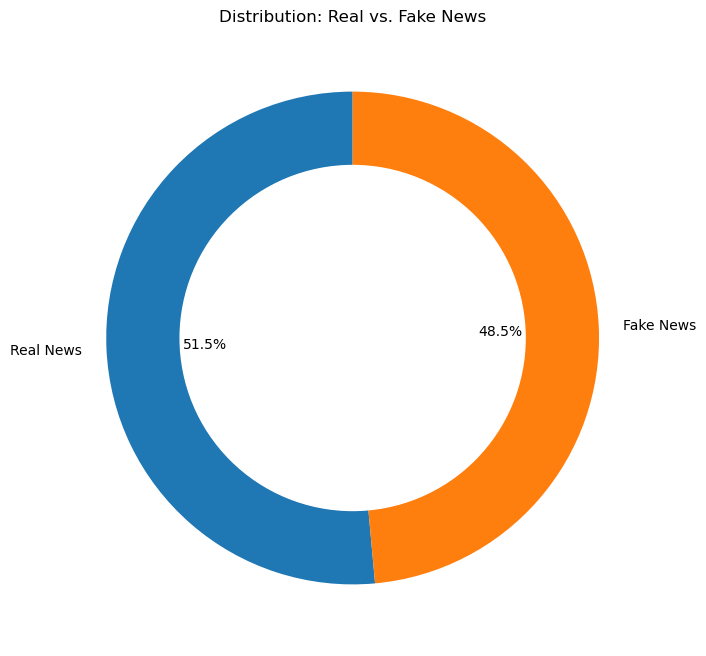

In [9]:
plt.figure(figsize=(8, 8))

counts = df['is_fake_news'].value_counts()

plt.pie(counts, 
        labels=['Real News', 'Fake News'], 
        autopct='%1.1f%%', 
        startangle=90
        )

plt.gca().add_artist(plt.Circle((0,0), 0.7, color='white'))

plt.title('Distribution: Real vs. Fake News')

# Spliting The Data

In [10]:
X = df['Headline']
y = df['is_fake_news']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train.shape

(27321,)

In [12]:
X_test.shape

(6831,)

# Text Processing with TF - IDF

In [18]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Models

## Random Forest

In [19]:
classifier = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=10, random_state=42)
classifier.fit(X_train_tfidf, y_train)

,n_estimators,200
,criterion,'entropy'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Model Evaluation

#### Evaluation

In [20]:
y_pred = classifier.predict(X_test_tfidf)

In [21]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8395549699897527

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.93      0.86      3529
           1       0.91      0.74      0.82      3302

    accuracy                           0.84      6831
   macro avg       0.85      0.84      0.84      6831
weighted avg       0.85      0.84      0.84      6831



#### Confusion Matrix

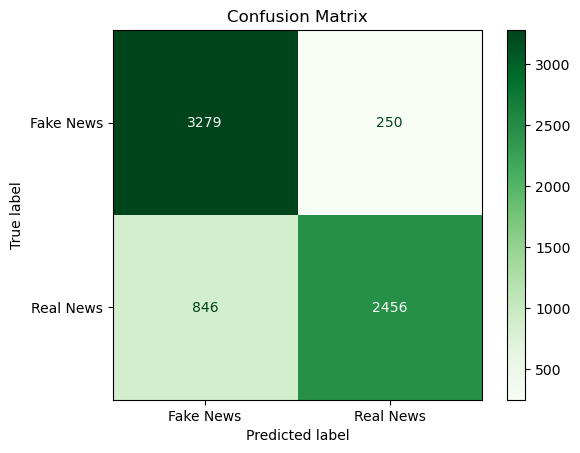

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Fake News', 'Real News'], cmap='Greens')
plt.title("Confusion Matrix")
plt.show()

#### Top 10 Features

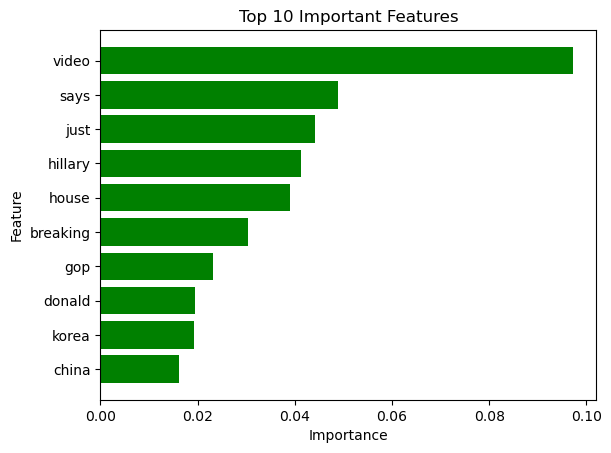

In [31]:
feature_names = vectorizer.get_feature_names_out()
importances = classifier.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features


plt.barh(range(len(indices)), importances[indices], align='center', color='green')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Top 10 Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Improving the Data Preprocessing

In [33]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import re

In [34]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/mac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mac/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Data Cleaning

In [37]:
df.dropna(subset=['Headline', 'is_fake_news'], inplace=True)
df.drop_duplicates(inplace=True)

In [38]:
df.shape

(32206, 2)

## Extenting Text Preprocessing

In [39]:
def preprocess_text(text):
    # Remove special characters, digits, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

In [41]:
df['cleaned_headline'] = df['Headline'].apply(preprocess_text)

In [44]:
X_base = df['Headline']  # For the model without enhanced preprocessing
X_enhanced = df['cleaned_headline']  # Enhanced preprocessing
y = df['is_fake_news']

In [45]:
X_enhanced_train, X_enhanced_test, y_enhanced_train, y_enhanced_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=42)

In [46]:
enhanced_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2), max_df=0.8, min_df=5)

In [47]:
X_enhanced_train_tfidf = enhanced_vectorizer.fit_transform(X_enhanced_train)
X_enhanced_test_tfidf = enhanced_vectorizer.transform(X_enhanced_test)

In [48]:
enhanced_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
enhanced_classifier.fit(X_enhanced_train_tfidf, y_enhanced_train)
enhanced_y_pred = enhanced_classifier.predict(X_enhanced_test_tfidf)

In [49]:
print("Enhanced Model Accuracy:", accuracy_score(y_enhanced_test, enhanced_y_pred))
print("\nEnhanced Model Classification Report:\n", classification_report(y_enhanced_test, enhanced_y_pred))

Enhanced Model Accuracy: 0.891182862465073

Enhanced Model Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      3233
           1       0.89      0.89      0.89      3209

    accuracy                           0.89      6442
   macro avg       0.89      0.89      0.89      6442
weighted avg       0.89      0.89      0.89      6442



## Confusion Matrix

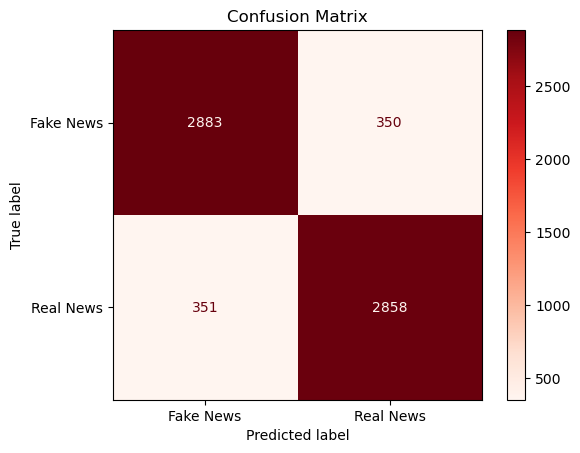

In [52]:
ConfusionMatrixDisplay.from_predictions(y_enhanced_test, enhanced_y_pred, display_labels=['Fake News', 'Real News'], cmap='Reds')
plt.title("Confusion Matrix")
plt.show()

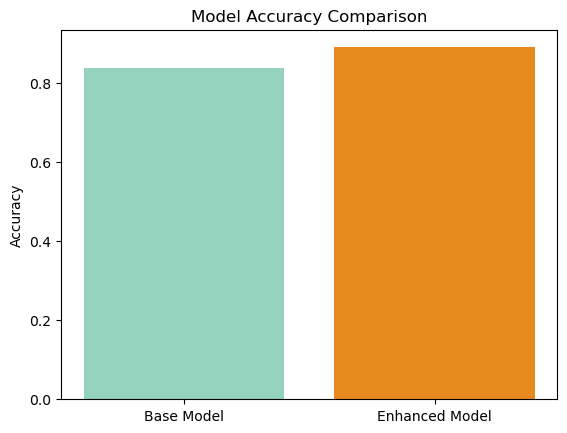

In [53]:
models = ['Base Model', 'Enhanced Model']
accuracies = [accuracy_score(y_test, y_pred), accuracy_score(y_enhanced_test, enhanced_y_pred)]

plt.bar(models, accuracies, color=['#94D2BD', '#e8891d'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

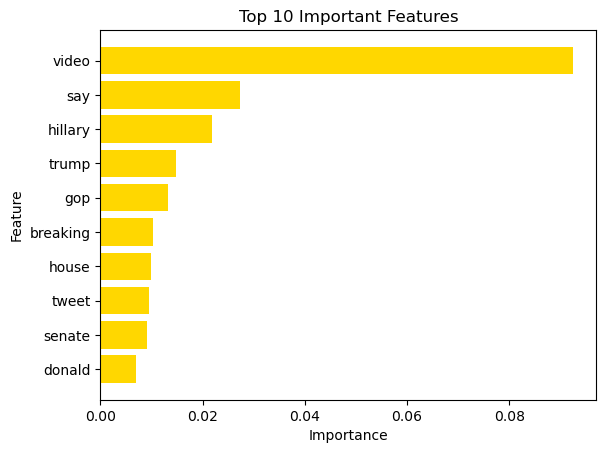

In [54]:
# Extract feature importance from the classifier
feature_names = enhanced_vectorizer.get_feature_names_out()
importances = enhanced_classifier.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features


plt.barh(range(len(indices)), importances[indices], align='center', color='gold')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Top 10 Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()